## Word 2 Vec 

In this notebook I will try to create a basic word2vec model using tensorflow. This notebook is based on a tensorflow tutorial, the link of which is given below. I will be demostrating a basic word embedding using the word2vec skip gram model. 

https://www.tensorflow.org/tutorials/word2vec

In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Get the data 

In [2]:
data_dir = "word2vec_data/words"  # local directory where the data is stored 
data_url = 'http://mattmahoney.net/dc/text8.zip' # actual data url 

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    '''
    This function fetches the data from the given url and stores it in the metioned local directory. 
    '''
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [4]:
words = fetch_words_data() 

#### checking the total number of words 

In [5]:
len(words)  

17005207

#### A Slice of words 

In [6]:
words[8000:8020]

['do',
 'not',
 'interact',
 'with',
 'them',
 'as',
 'often',
 'as',
 'non',
 'autistic',
 'children',
 'children',
 'with',
 'autism',
 'often',
 'appear',
 'to',
 'prefer',
 'being',
 'alone']

#### An example sentence 

In [7]:
for w in words[8000:8040]:
    print(w,end=' ')

do not interact with them as often as non autistic children children with autism often appear to prefer being alone to the company of others and may passively accept such things as hugs and cuddling without reciprocating or resist attention 

### Building Word Counts

In [10]:
from collections import Counter

#### Counter Example 

In [11]:
mylist = ["one",'one','two','two','two','three']

In [12]:
Counter(mylist)

Counter({'one': 2, 'two': 3, 'three': 1})

In [13]:
Counter(mylist).most_common(1) # returns the most common word by count 

[('two', 3)]

In [14]:
Counter(mylist).most_common(2) # returns 2 most common words  

[('two', 3), ('one', 2)]

### Creating Word Data and Vocab

In [15]:
def create_counts(vocab_size = None):
    
    '''
    This funtion creates a vocabulary of 'vocab_size' from the downloaded bag of words. 
    '''
    vocab = [] + Counter(words).most_common(vocab_size)
    
    vocab = np.array([word for word,_ in vocab])
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word, 0) for word in words])
    
    return data,vocab
        

#### arbitary vocab size 

In [16]:
vocab_size = 50000 

In [17]:
data,vocabulary = create_counts(vocab_size=vocab_size)

#### original data 

In [18]:
data.shape  

(17005207,)

####  newly created vocabulary

In [19]:
vocabulary.shape  

(50000,)

####  the 50th word in the vocabulary and its corresponding index  

In [20]:
print((words[50],data[50]))  

('organization', 708)


### Function for Batches 

Direct from the TensorFlow Docs

In [21]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [22]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [23]:
batch.shape

(8,)

In [24]:
labels.shape

(8, 1)

### Tensorflow Model 

In [25]:
batch_size = 64

embedding_size = 100  # Dimension of embedding vector

skip_window = 1     # How many words to consider left and right (the bigger, the longer the training)    

num_skips = 2       # How many times to reuse an input to generate a label


We pick a random validation set to sample nearest neighbors. Here we limit the validation samples to the words that have a low numeric ID, which by construction are also the most frequent.

In [26]:
valid_size = 16   # Random set of words to evaluate similarity on.

valid_window = 100  # Only pick dev samples in the head of the distribution.

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_sampled = 64   # Number of negative examples to sample.

learning_rate = 0.01 # Model Learning Rate

vocabulary_size = 50000 # How many words in vocab

In [27]:
tf.reset_default_graph()

####  Placeholders and Constants

In [28]:
train_inputs = tf.placeholder(tf.int32, shape=[None])

train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

#### Variables

In [29]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)

embeddings = tf.Variable(init_embeds)

#### Embedding 

In [30]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

#### NCE Loss

In [31]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

#### Compute the average NCE loss for the batch.

In [32]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

#### Optimizer

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

#### Compute the cosine similarity between minibatch examples and all embeddings.

In [34]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Add variable initializer.

In [35]:
init = tf.global_variables_initializer()

#### Session 

#### The number of steps usually needs to be quite large to get good results, training takes a long time! Since I am running this on a CPU, and since this notebook is just for demonstration, I am limiting the number of steps to a more moderate number. 

In [36]:
num_steps = 10000

with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op 
        # including it in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 500 == 0:
            if step > 0:
                average_loss /= 500
            # The average loss is an estimate of the loss over the last 500 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  326.279296875
Average loss at step  500 :  3954.8565575561524
Average loss at step  1000 :  11413.358970581055
Average loss at step  1500 :  15269.312562011719
Average loss at step  2000 :  19376.564771392823
Average loss at step  2500 :  18693.230992553712
Average loss at step  3000 :  20870.41563800049
Average loss at step  3500 :  20538.230887886046
Average loss at step  4000 :  24161.39792706299
Average loss at step  4500 :  24399.755880607605
Average loss at step  5000 :  27214.551909416197
Average loss at step  5500 :  27081.05668585205
Average loss at step  6000 :  27435.788671616556
Average loss at step  6500 :  27812.670858642578
Average loss at step  7000 :  27675.56401412201
Average loss at step  7500 :  30889.085540161133
Average loss at step  8000 :  32424.376909930044
Average loss at step  8500 :  29985.493119407653
Average loss at step  9000 :  32094.97290016246
Average loss at step  9500 :  33170.93437811279


### Visualizing Results

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

### TSNE
Dimensionality reduction to 2-D vectors (down from 150)

In [39]:
final_embeddings.shape

(50000, 100)

In [40]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [41]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [42]:
labels = [vocabulary[i] for i in range(plot_only)]

In [43]:
low_dim_embs.shape

(2000, 2)

(-10, 10)

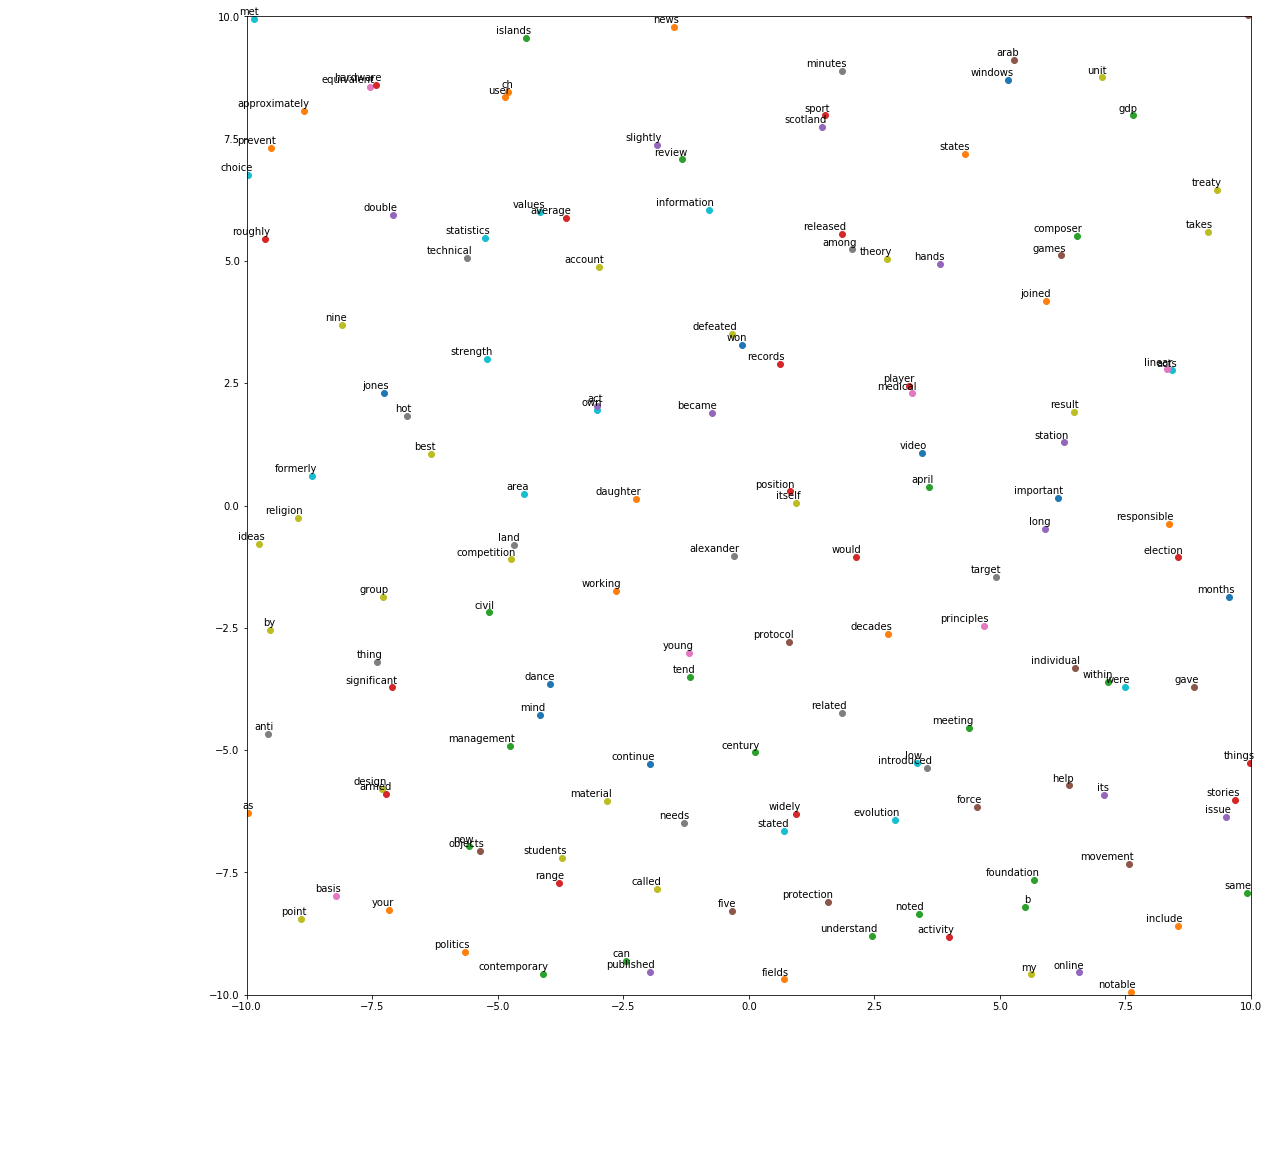

In [44]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

A basic word to vec model is just trying to maximize to cosine similarity or inner product between two word vectors. This means, words with similar meaning will be close to each other in a two dimentional plane. As we can see the represntations are just starting to get better even after 10000 stpes. The accuracy of the representations largely depends on two hyperparementers,  the embedding dimentions (number of features used to caputure the word representations) and number of epocs or steps.  

(-30, 30)

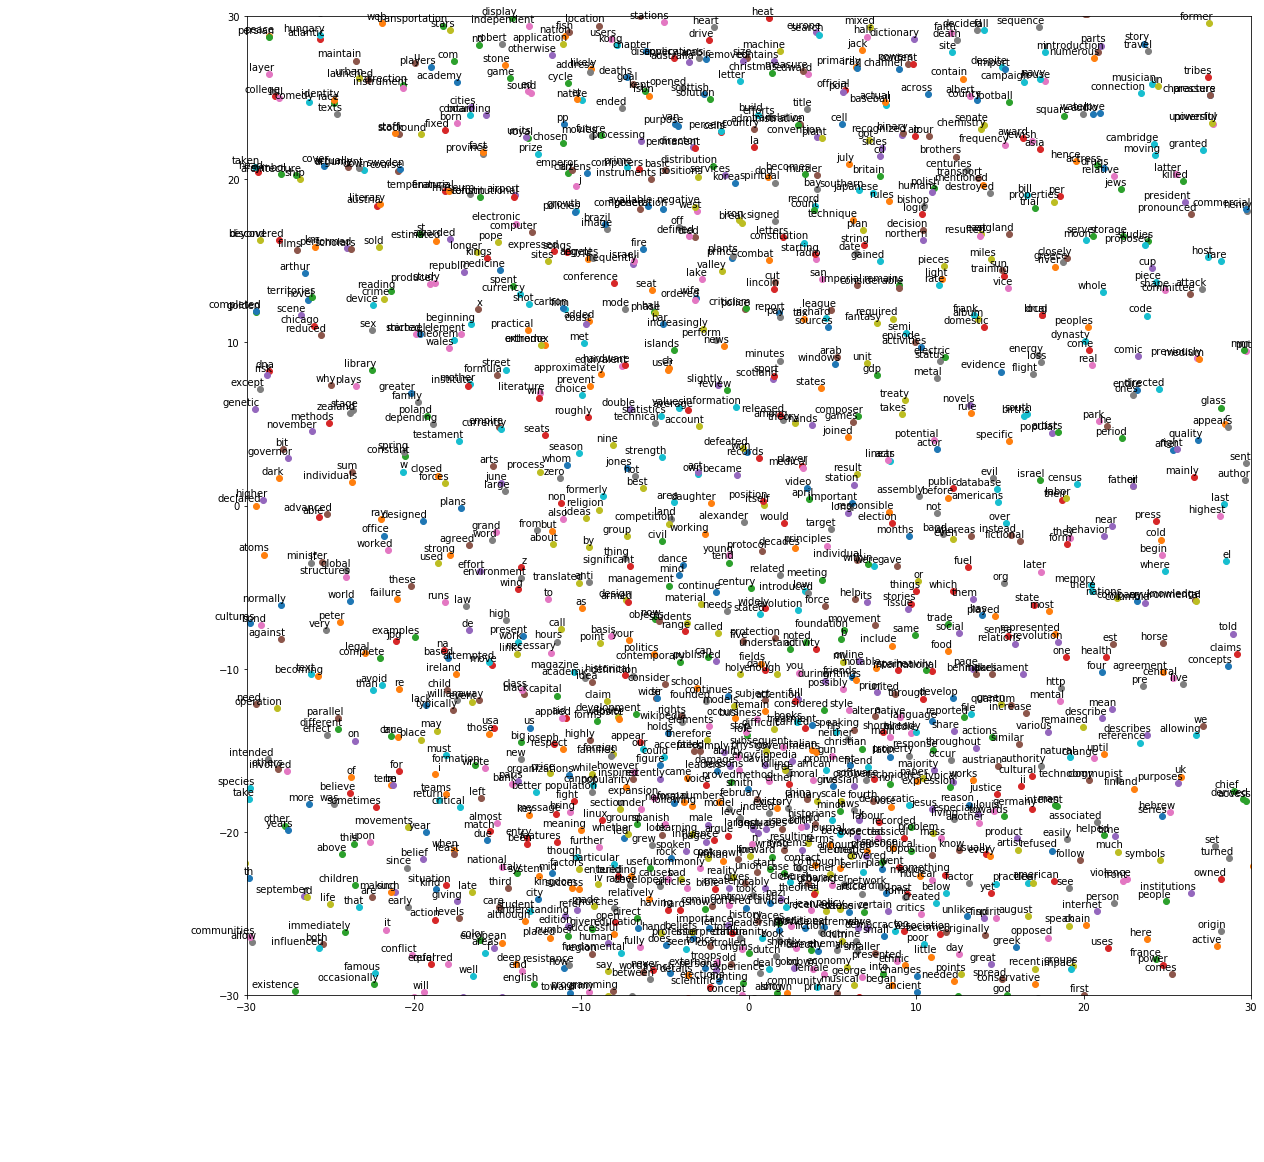

In [45]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-30,30)
plt.ylim(-30,30)